# Analyzing the effect of income and area of residence on quality of education

 
## Introduction
The Scholastic Aptitude Test (SAT) is a standardized test taken by most high school students across the United States (and some international students), often used for post-secondary admissions. The question we will try to answer with the project is: What SAT score is a NYC student likely to get as a result of their income and their school’s location and student enrollment? A dataset listing the average SAT scores per school in New York will be used; this dataset also lists the zip codes and student enrollment of each school. The average SAT scores of all schools in each zip code will then be compared with data from an income per zip code database. 

We will use linear regression to predict SAT scores given household income and student enrollment. From the average SAT scores dataset, we will be using Average SAT Scores (math, reading, writing), and student enrollment. From the average income data, we will be using Zip.Code, total_pop, total_income, and avg_income. We will visualize the results with a scatterplot (average SAT scores per zip code vs. average income per zip code)

We expect higher income ZIP codes and higher student enrollment will have higher average SAT scores, assuming that those who live in a higher income area and bigger school will receive better education. If data suggests so, actions could be taken to minimize the effect of someone's place of residence on their education. An example of a future question this could lead to is: Are there other environmental factors affecting average SAT scores for specific areas?

After visualizing the correlation between variables using the ggpairs function, we found that student enrollment has a higher correlation to SAT scores than zip codes. 


## Preliminary exploratory data analysis

### Run before:

In [40]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(cowplot)

### Download files

In [41]:
sat_scores <- read_csv("https://raw.githubusercontent.com/emi31770/DSCI-Project/main/datasets/sat_scores.csv")
zip_income <- read_csv("https://raw.githubusercontent.com/emi31770/DSCI-Project/main/datasets/zipcodes_income.csv")
colnames(sat_scores) <- make.names(colnames(sat_scores))
colnames(zip_income) = make.names(colnames(zip_income))
write_csv(sat_scores, "sat.csv")
write_csv(zip_income, "zip.csv")

Parsed with column specification:
cols(
  .default = col_character(),
  `Zip Code` = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  `Start Time` = col_time(format = ""),
  `End Time` = col_time(format = ""),
  `Student Enrollment` = col_double(),
  `Average Score (SAT Math)` = col_double(),
  `Average Score (SAT Reading)` = col_double(),
  `Average Score (SAT Writing)` = col_double()
)

See spec(...) for full column specifications.

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)



In [42]:
zip_income <- read_csv("zip.csv")
sat_scores <- read_csv("sat.csv")

head(zip_income, 5)
head(sat_scores, 5)

Parsed with column specification:
cols(
  state = col_character(),
  zipcode = col_double(),
  total_pop = col_double(),
  total_income = col_double(),
  country = col_character(),
  avg_income = col_double()
)

Parsed with column specification:
cols(
  .default = col_character(),
  Zip.Code = col_double(),
  Latitude = col_double(),
  Longitude = col_double(),
  Start.Time = col_time(format = ""),
  End.Time = col_time(format = ""),
  Student.Enrollment = col_double(),
  Average.Score..SAT.Math. = col_double(),
  Average.Score..SAT.Reading. = col_double(),
  Average.Score..SAT.Writing. = col_double()
)

See spec(...) for full column specifications.



state,zipcode,total_pop,total_income,country,avg_income
<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
AK,0,345220,25354974,USA,73445.84
AK,99501,7690,612242,USA,79615.34
AK,99502,11860,1000685,USA,84374.79
AK,99503,7510,462394,USA,61570.44
AK,99504,19440,1176109,USA,60499.43


School.ID,School.Name,Borough,Building.Code,Street.Address,City,State,Zip.Code,Latitude,Longitude,⋯,End.Time,Student.Enrollment,Percent.White,Percent.Black,Percent.Hispanic,Percent.Asian,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,Percent.Tested
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<time>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>
02M260,Clinton School Writers and Artists,Manhattan,M933,425 West 33rd Street,Manhattan,NY,10001,40.75321,-73.99786,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
06M211,Inwood Early College for Health and Information Technologies,Manhattan,M052,650 Academy Street,Manhattan,NY,10002,40.86605,-73.92486,⋯,15:00:00,87,3.4%,21.8%,67.8%,4.6%,NA,NA,NA,NA
01M539,"New Explorations into Science, Technology and Math High School",Manhattan,M022,111 Columbia Street,Manhattan,NY,10002,40.71873,-73.97943,⋯,16:00:00,1735,28.6%,13.3%,18.0%,38.5%,657,601,601,91.0%
02M294,Essex Street Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,⋯,14:45:00,358,11.7%,38.5%,41.3%,5.9%,395,411,387,78.9%
02M308,Lower Manhattan Arts Academy,Manhattan,M445,350 Grand Street,Manhattan,NY,10002,40.71687,-73.98953,⋯,15:00:00,383,3.1%,28.2%,56.9%,8.6%,418,428,415,65.1%


In [43]:
zip_income <- zip_income %>% 
                filter(state == "NY", country == "USA") %>% 
                mutate(Zip.Code = zipcode) %>% 
                select(Zip.Code, total_pop, total_income, avg_income)

sat_scores <- sat_scores %>% 
                mutate(total_score_avg = Average.Score..SAT.Math. + Average.Score..SAT.Reading. + Average.Score..SAT.Writing.) %>%
                select(Zip.Code, Student.Enrollment, total_score_avg, Average.Score..SAT.Math., Average.Score..SAT.Reading., Average.Score..SAT.Writing.) %>%
                na.omit() %>%
                group_by(Zip.Code) %>%
                summarize_all("mean")


joined_tables <- merge(x = sat_scores,y = zip_income, by = "Zip.Code")
joined_tables = joined_tables %>%
                        mutate(Zip.Code = as_factor(Zip.Code))


head(joined_tables, 5)

,Zip.Code,Student.Enrollment,total_score_avg,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,total_pop,total_income,avg_income
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10002,504.7273,1358.909,472.9091,448.5455,437.4545,42400,2718913,64125.31
2,10003,693.2000,1323.600,449.6000,443.4000,430.6000,29270,8191737,279868.02
3,10004,519.2500,1380.250,463.0000,462.0000,455.2500,2470,944925,382560.73
4,10006,747.5000,1268.000,429.5000,419.0000,419.5000,2510,577145,229938.25
5,10009,666.0000,1327.000,454.0000,428.0000,445.0000,33200,2948597,88813.16


In [44]:
pop_parameters <- joined_tables %>%
                    summarize(pop_mean = mean(total_score_avg),
                            pop_med = median(total_score_avg),
                            pop_sd = sd(total_score_avg))

pop_parameters

pop_mean,pop_med,pop_sd
<dbl>,<dbl>,<dbl>
1309.205,1268,167.6026


Warning message:
“Removed 2 rows containing missing values (geom_bar).”


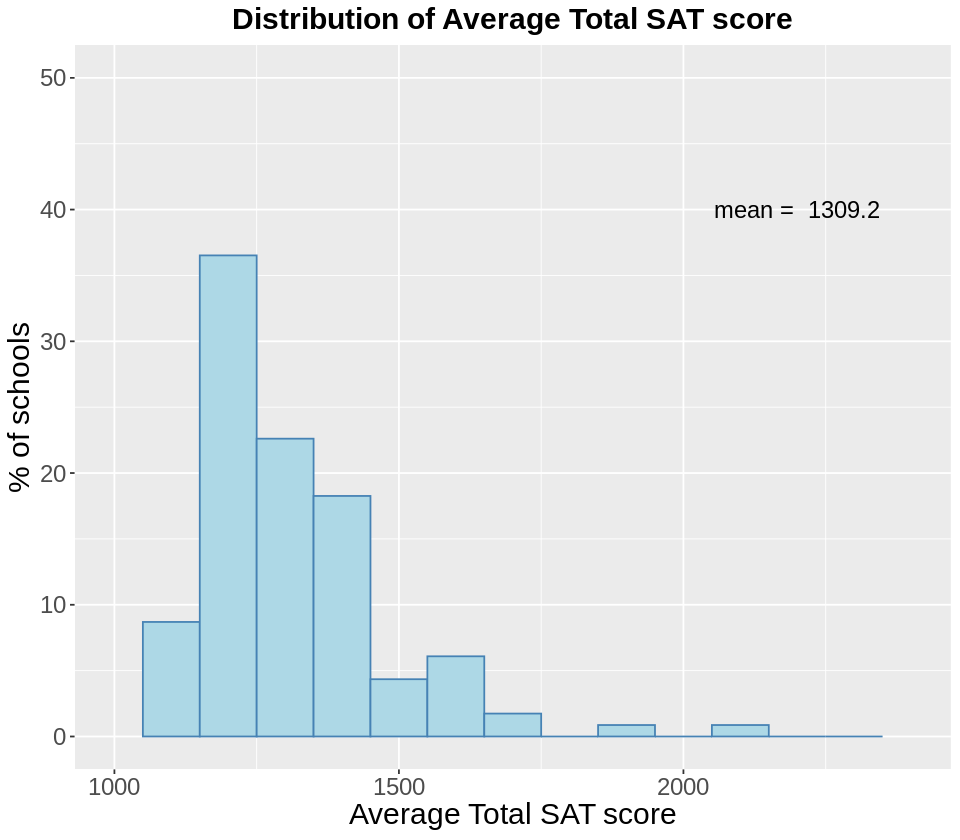

In [45]:
options(repr.plot.width = 8, repr.plot.height = 7)

SAT_dist_plot <- ggplot(joined_tables, aes(x = total_score_avg)) +
                   geom_histogram(aes(y = 100 * stat(count) / sum(stat(count))),
                   binwidth = 100,
                   fill = "lightblue",
                   color = "steelblue") +
                   ylab("% of schools") +
                   xlab("Average Total SAT score") + 
                   theme(text = element_text(size = 18)) +
                   ggtitle("Distribution of Average Total SAT score") +
                   theme(plot.title = element_text(size = 18)) +
                   theme(plot.title = element_text(face = "bold")) +
                   theme(plot.title = element_text(hjust = 0.5)) +
                   annotate("text", x = 2200, y = 40, label = paste("mean = ", round(mean(pop_parameters$pop_mean), 1)), cex = 5) +
                   xlim(c(1000, 2400)) +
                   ylim(c(0, 50))

SAT_dist_plot 

In [46]:
n_data <- nrow(joined_tables)

n_data

[1] 115

replicate,Zip.Code,Student.Enrollment,total_score_avg,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,total_pop,total_income,avg_income
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,10011,684.0000,1360.167,460.3333,453.6667,446.1667,30370,9331779,307269.64
2,10456,440.0000,1181.900,399.0000,392.3000,390.6000,41000,1209535,29500.85
3,10466,400.6667,1173.333,397.0000,393.0000,383.3333,32980,1388485,42100.82
4,11203,390.8571,1186.143,392.2857,399.4286,394.4286,37810,1679309,44414.41
5,11412,599.0000,1241.000,405.0000,427.0000,409.0000,19770,945365,47818.16
6,10023,904.8571,1433.143,479.8571,480.2857,473.0000,34740,12391069,356680.17


replicate,Zip.Code,Student.Enrollment,total_score_avg,Average.Score..SAT.Math.,Average.Score..SAT.Reading.,Average.Score..SAT.Writing.,total_pop,total_income,avg_income
<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
70,11218,605.0,1490,502,495.0,493.0,33320,2212234,66393.58
71,11361,3336.0,1487,523,479.0,485.0,14080,1014165,72028.76
72,10128,697.0,1300,435,440.0,425.0,33540,12570244,374783.66
73,10021,541.0,1889,641,617.0,631.0,23600,12798847,542324.03
74,11434,641.5,1176,388,401.5,386.5,33550,1548972,46169.06
75,10454,558.5,1111,382,376.0,353.0,15940,488519,30647.37


[1] 75 10

`summarise()` ungrouping output (override with `.groups` argument)



replicate,sample_mean_75
<int>,<dbl>
1,1360.167
2,1181.900
3,1173.333
4,1186.143
5,1241.000
6,1433.143


replicate,sample_mean_75
<int>,<dbl>
70,1490
71,1487
72,1300
73,1889
74,1176
75,1111


Warning message:
“Removed 2 rows containing missing values (geom_bar).”


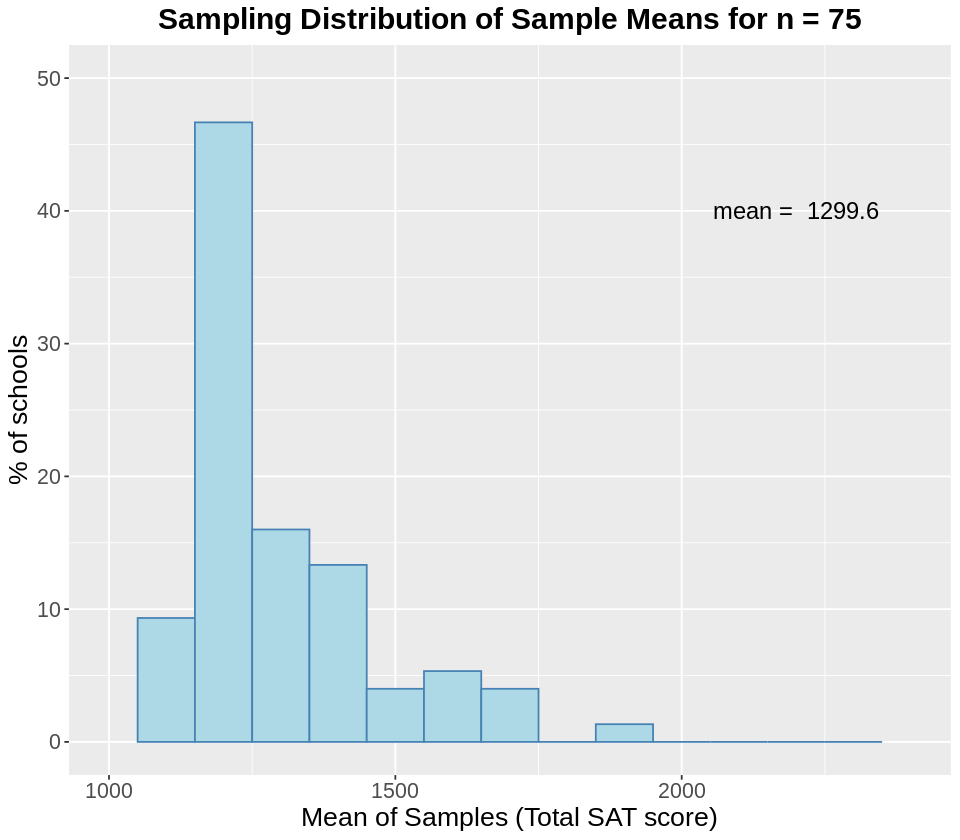

In [47]:
set.seed(2021)

samples_75 <- rep_sample_n(joined_tables, size = 1, reps = 75)

head(samples_75)
tail(samples_75)
dim(samples_75)

sample_estimates_75 <- samples_75 %>%
                    group_by(replicate) %>%
                    summarize(sample_mean_75 = mean(total_score_avg))

head(sample_estimates_75)
tail(sample_estimates_75)


sampling_distribution_75 <- ggplot(sample_estimates_75, aes(sample_mean_75)) +
                            geom_histogram(aes(y = 100 * stat(count) / sum(stat(count))),
                            binwidth = 100,
                            fill = "lightblue",
                            color = "steelblue") +
                            xlab("Mean of Samples (Total SAT score)") +
                            ylab("% of schools") +
                            theme(text = element_text(size = 16)) +
                            ggtitle("Sampling Distribution of Sample Means for n = 75") +
                            theme(plot.title = element_text(size = 18)) +
                            theme(plot.title = element_text(face = "bold")) +
                            theme(plot.title = element_text(hjust = 0.5)) +
                            annotate("text", x = 2200, y = 40, label = paste("mean = ", round(mean(sample_estimates_75$sample_mean_75), 1)), cex = 5) +
                            xlim(c(1000, 2400)) +
                            ylim(c(0, 50))


sampling_distribution_75

Warning message:
“Removed 2 rows containing missing values (geom_bar).”
Warning message:
“Removed 2 rows containing missing values (geom_bar).”


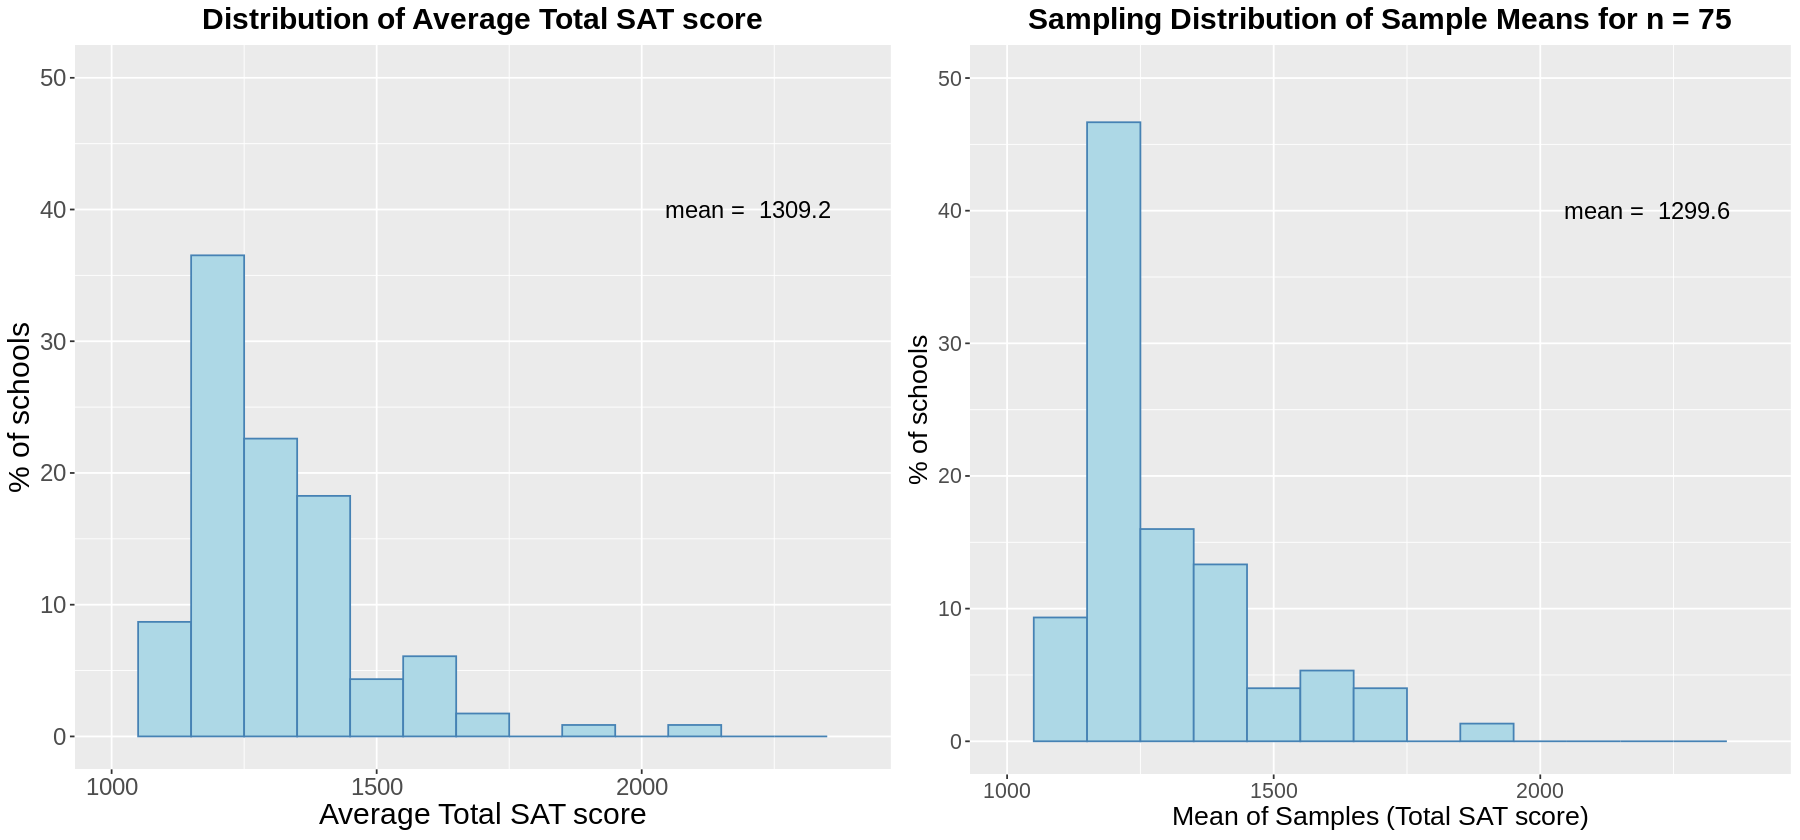

In [48]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(SAT_dist_plot, sampling_distribution_75, ncol = 2)

Both the distribution plots using total population and the sample population of 75 (bootstrap sample) have a mean around 1300, and are right-skewed. Therefore, we can hypothesize that other samples will look similar to this sample's bootstrap distribution. 

In [49]:
set.seed(4321)

sat_split <- initial_split(joined_tables, prop = 0.75, strata = total_score_avg)
sat_training <- training(sat_split)
sat_testing <- testing(sat_split)

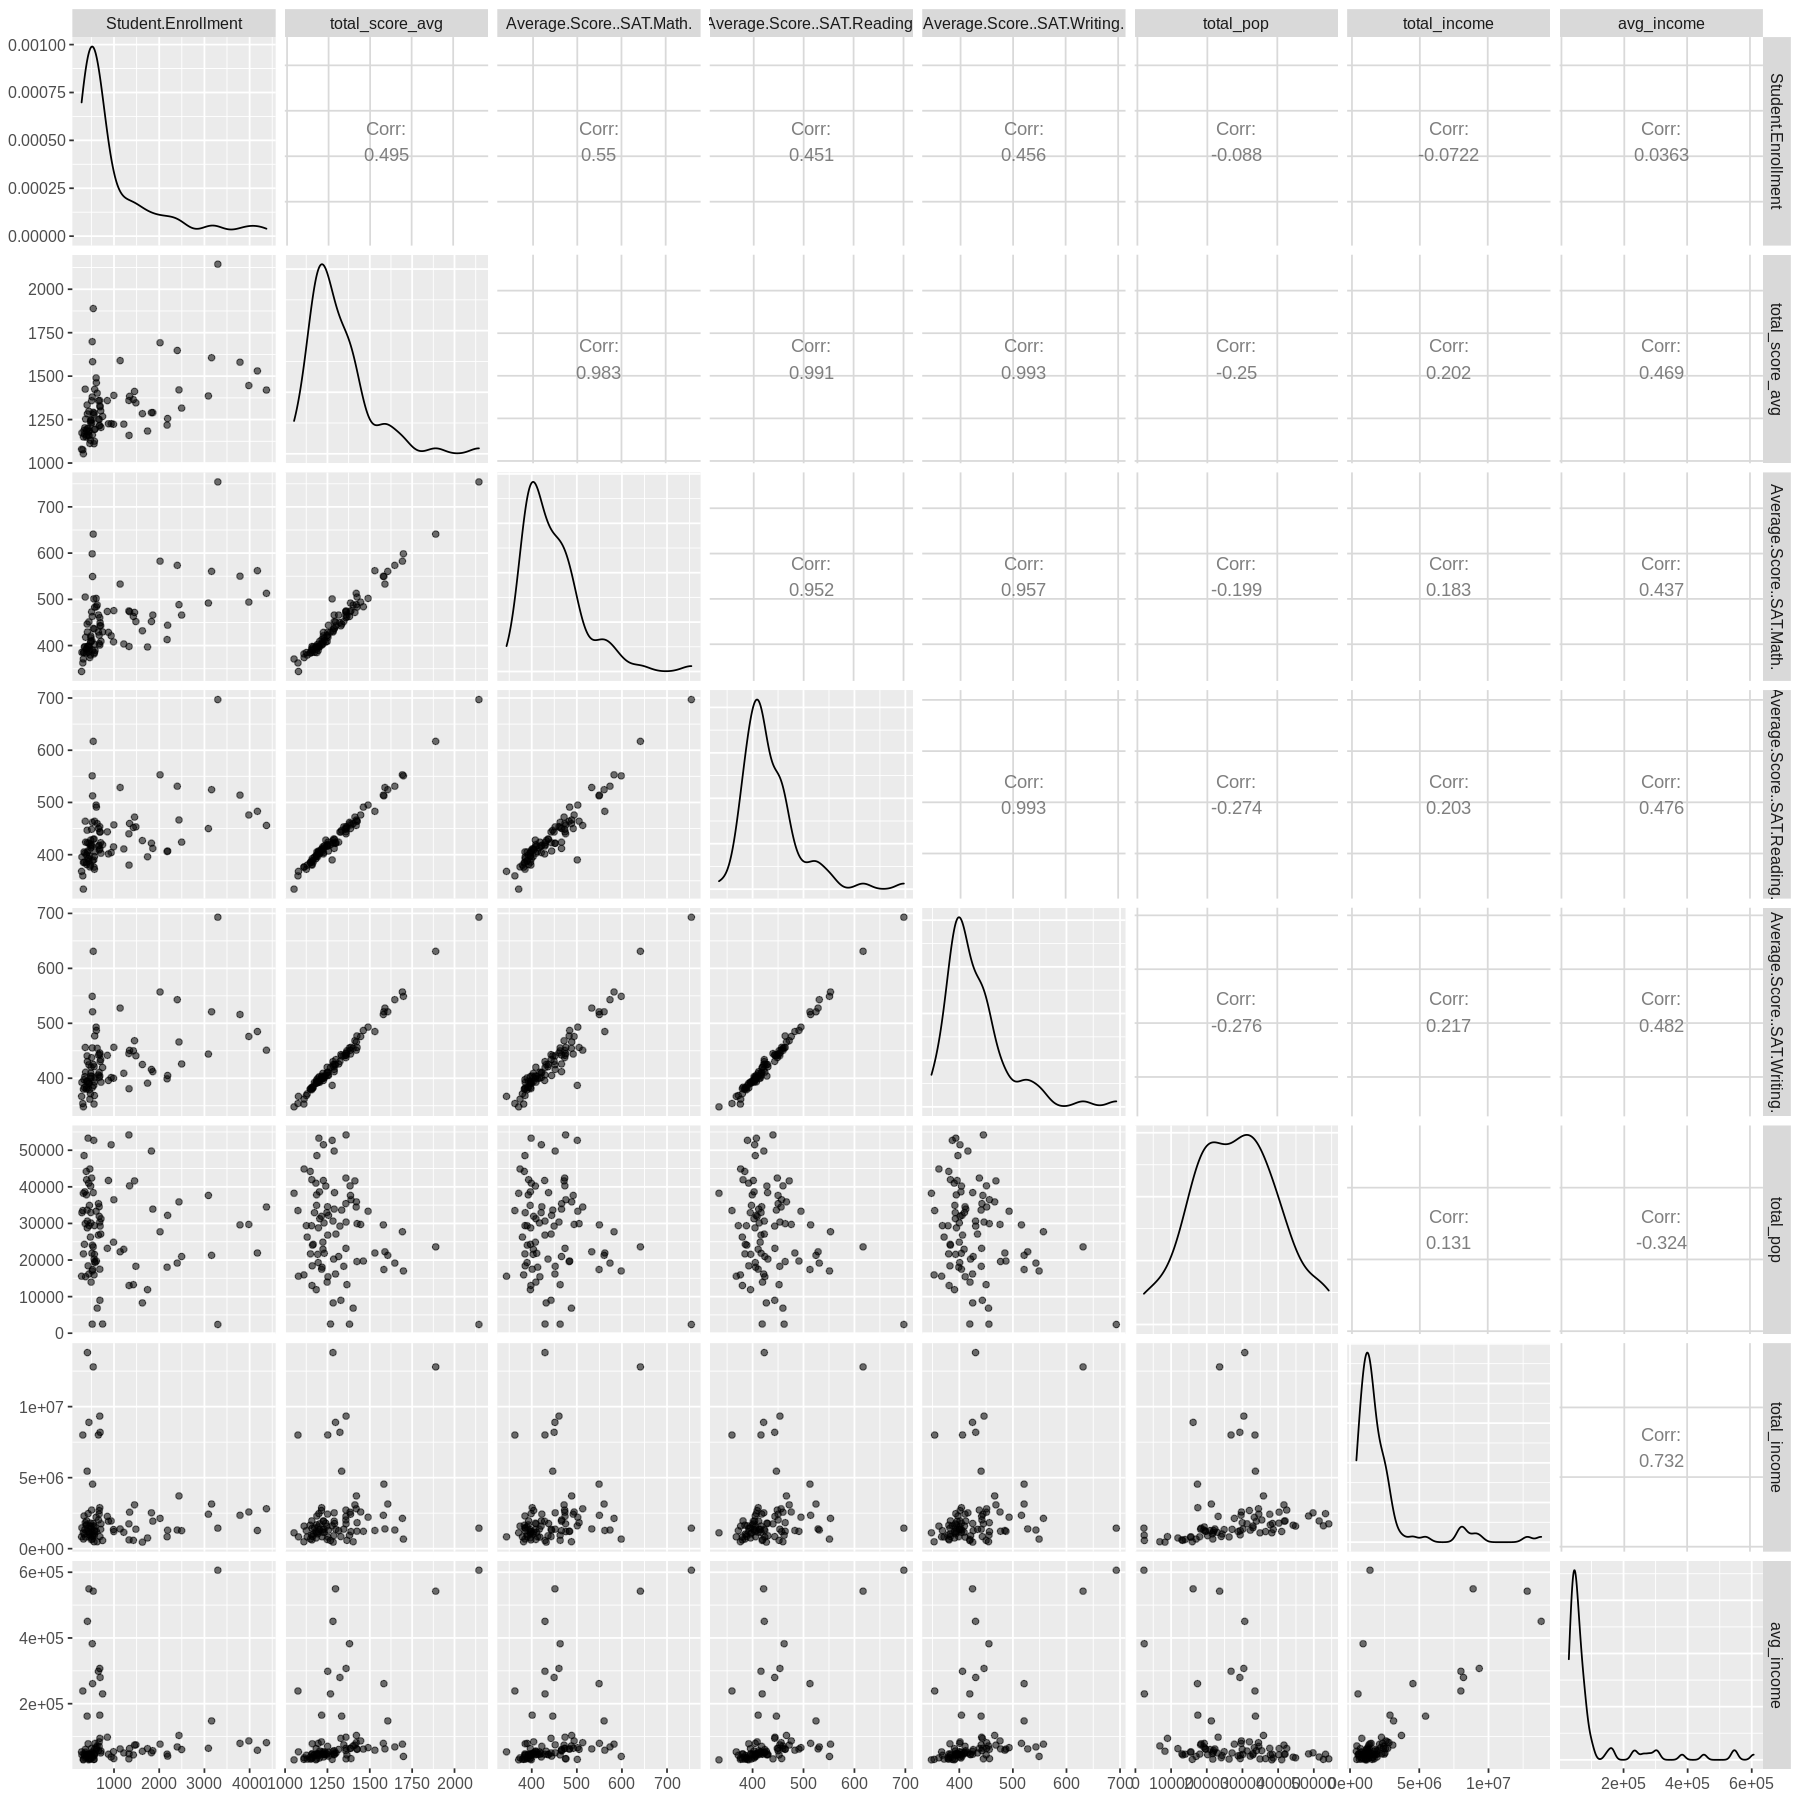

In [50]:
options(repr.plot.width = 15, repr.plot.height = 15)

sat_eda <- sat_training %>%
                select(-Zip.Code) %>%
                ggpairs(mapping = aes(alpha = 0.4)) +
                theme(text = element_text(size = 12))

sat_eda

since student enrollment and average income has higher correlation (to average SAT score than the other variables, they'll be the predictors we choose to use. 

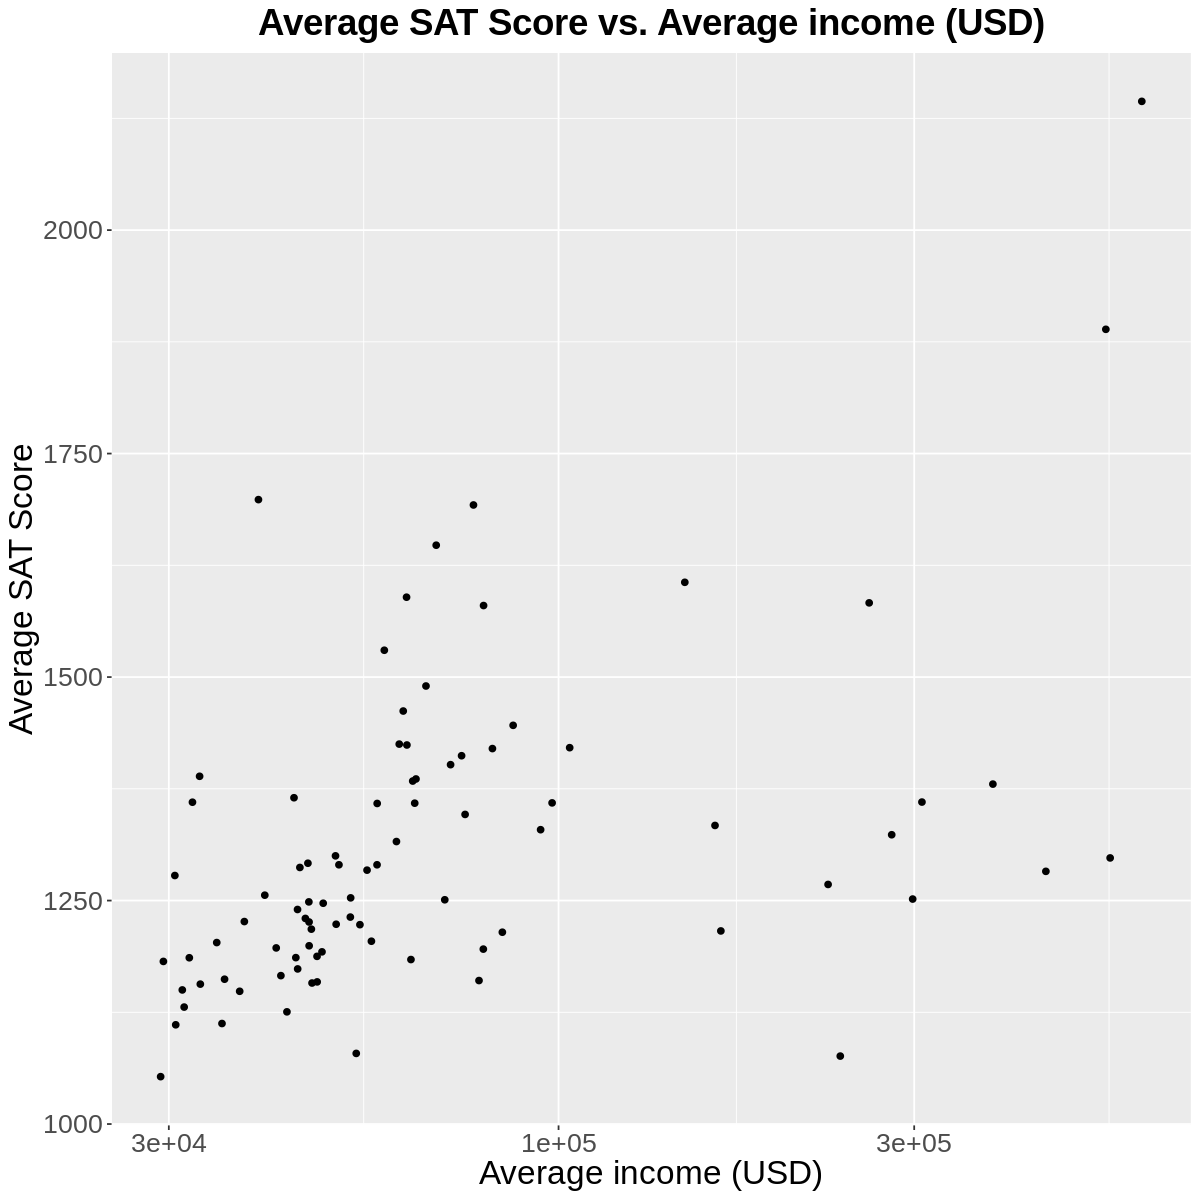

In [51]:
options(repr.plot.width = 10, repr.plot.height = 10)

scores_income <- ggplot(sat_training, aes(x = avg_income, y = total_score_avg)) +
                    geom_point() +
                    xlab("Average income (USD)") +
                    scale_x_log10() +
                    ylab("Average SAT Score") +
                    theme(text = element_text(size = 20)) +
                    ggtitle("Average SAT Score vs. Average income (USD)") +
                    theme(plot.title = element_text(size = 22)) +
                    theme(plot.title = element_text(face = "bold")) +
                    theme(plot.title = element_text(hjust = 0.5)) 

scores_income

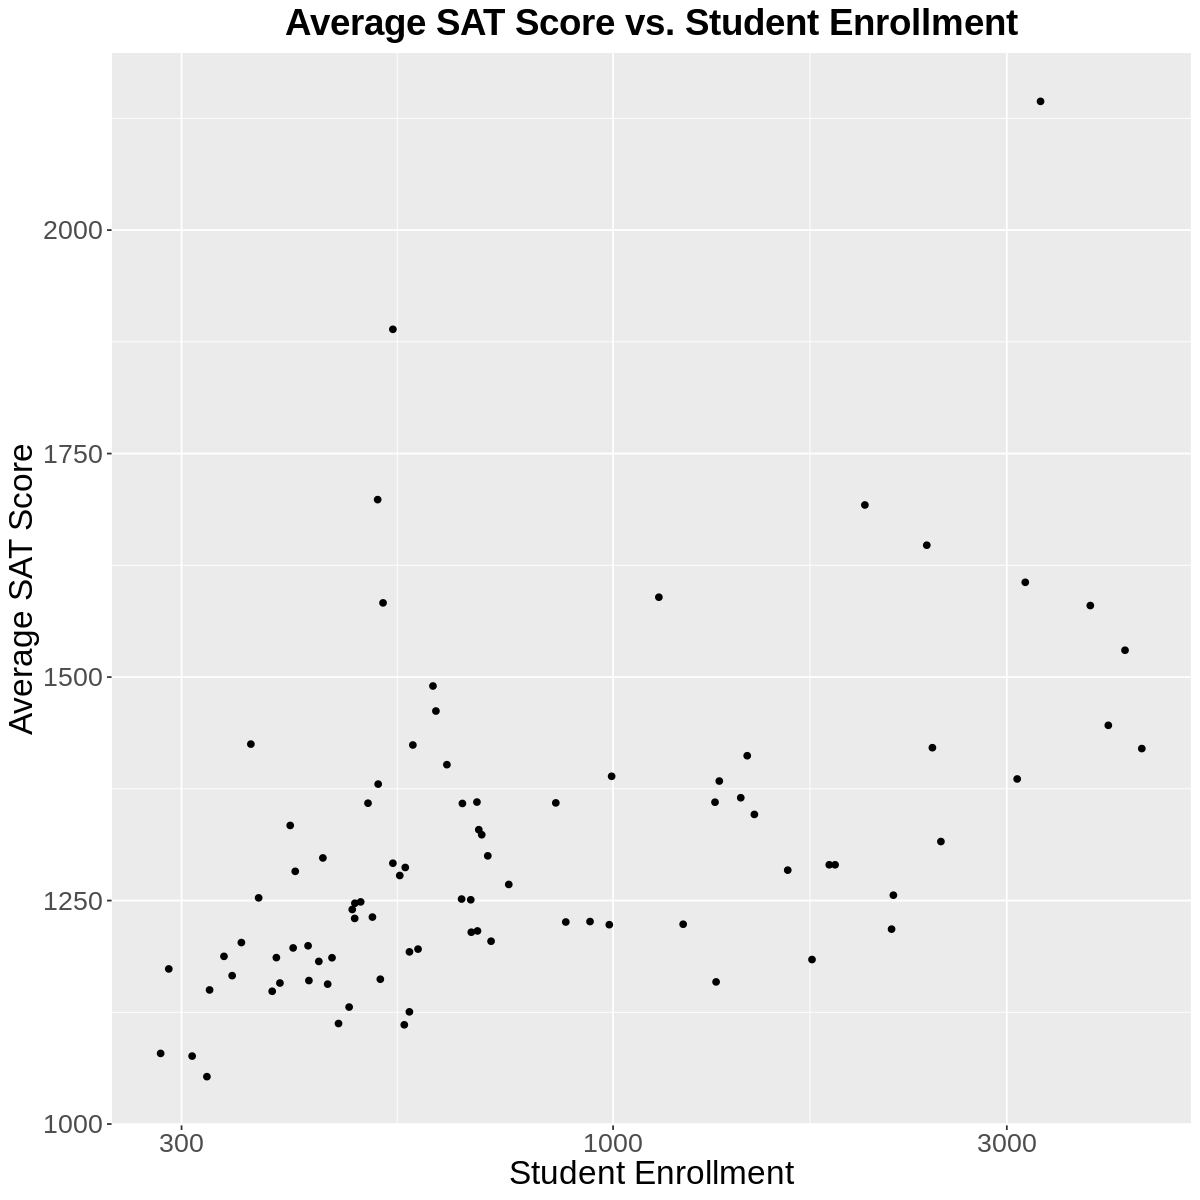

In [39]:
options(repr.plot.width = 10, repr.plot.height = 10)

scores_students <- ggplot(sat_training, aes(x = Student.Enrollment, y = total_score_avg)) +
                    geom_point() +
                    xlab("Student Enrollment") +
                    scale_x_log10() +
                    ylab("Average SAT Score") +
                    theme(text = element_text(size = 20)) +
                    ggtitle("Average SAT Score vs. Student Enrollment") +
                    theme(plot.title = element_text(size = 22)) +
                    theme(plot.title = element_text(face = "bold")) +
                    theme(plot.title = element_text(hjust = 0.5)) 

scores_students

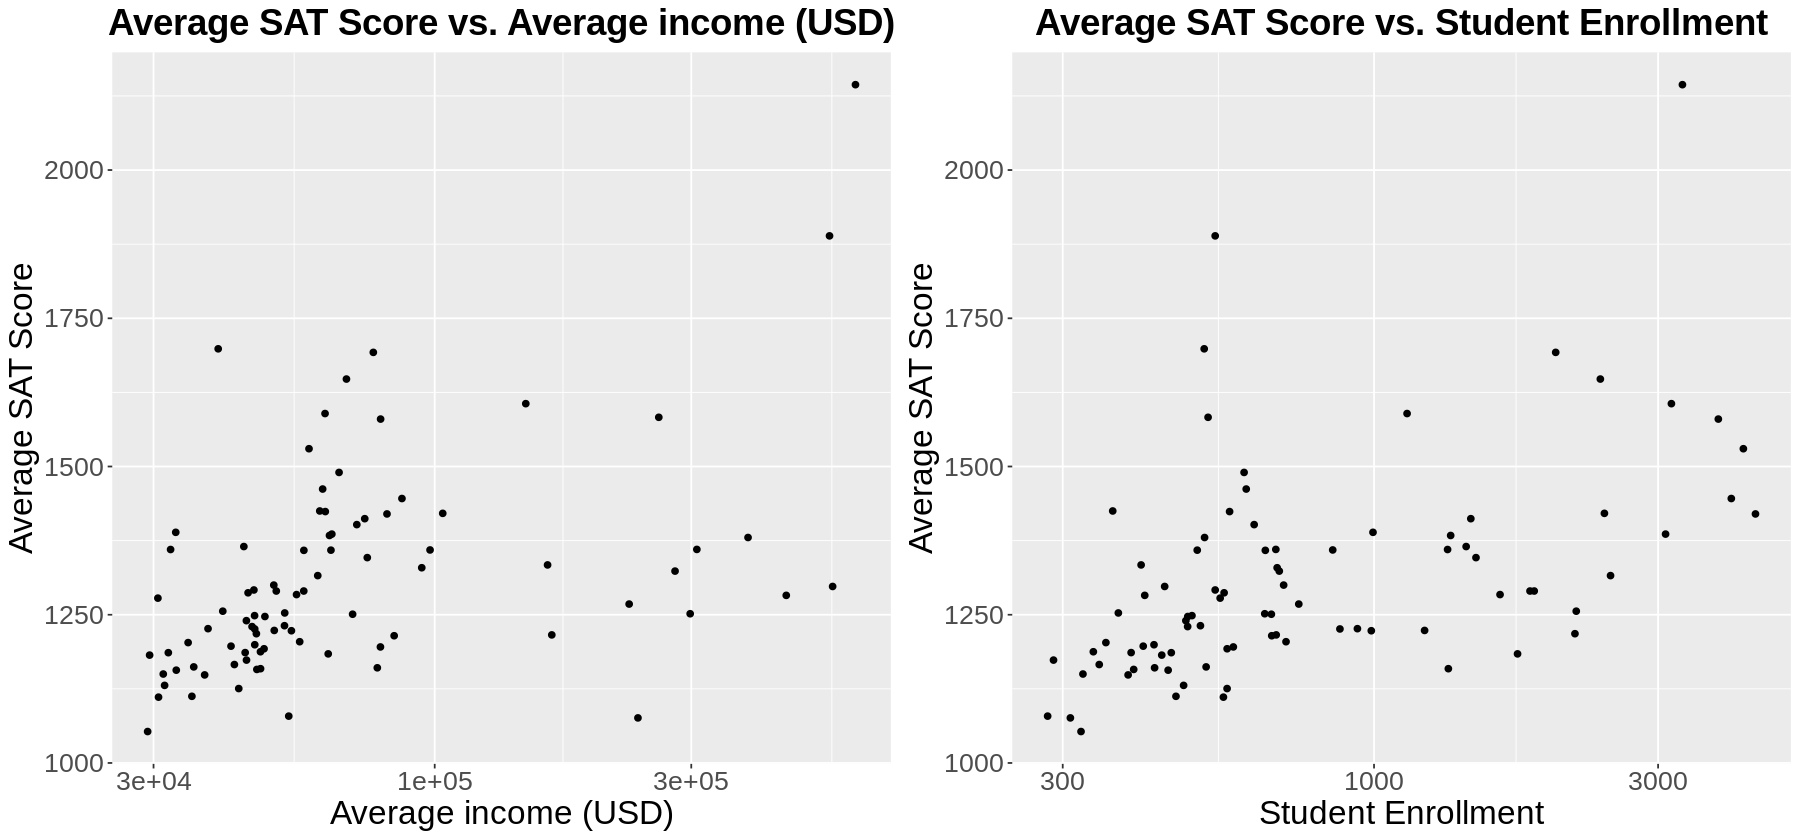

In [14]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(scores_income, scores_students, ncol = 2)

## Data Analysis

### Methods
The ggpairs revealed that the relationship between income or student enrollment and total SAT score wasn’t very strong, and was around 0.5. Thus, we used knn regression instead of linear regression to gain more accurate predictions.


In [32]:
set.seed(2021)

sat_vfold <- vfold_cv(sat_training, v = 5, strata = total_score_avg)

k_vals <- tibble(neighbors = seq(from = 1, to=20))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
                set_engine("kknn") %>%
                set_mode("regression")

sat_recipe <- recipe(total_score_avg ~ Student.Enrollment + avg_income, data = sat_training) %>%
                step_scale(all_predictors()) %>% 
                step_center(all_predictors())

sat_workflow <- workflow() %>%
                add_recipe(sat_recipe) %>%
                add_model(knn_spec)

sat_results <- sat_workflow %>%
                tune_grid(resamples = sat_vfold, grid = k_vals) %>%
                collect_metrics() %>%
                filter(.metric == "rmse")

sat_results

k_min <- sat_results %>% 
            filter(mean == min(mean)) %>% 
            pull(neighbors)

k_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,191.7310,5,19.95759,Model01
2,rmse,standard,167.7382,5,14.17906,Model02
3,rmse,standard,168.6480,5,15.45918,Model03
4,rmse,standard,167.6123,5,16.68545,Model04
5,rmse,standard,163.9438,5,17.87449,Model05
6,rmse,standard,162.9491,5,17.49002,Model06
7,rmse,standard,157.1380,5,17.88009,Model07
8,rmse,standard,151.4284,5,17.60878,Model08
9,rmse,standard,152.0155,5,17.65508,Model09


[1] 8

In [33]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = k_min) %>%
                set_engine("kknn") %>%
                set_mode("regression")

sat_workflow <- workflow() %>%
                add_recipe(sat_recipe) %>%
                add_model(knn_spec)

sat_fit <- sat_workflow %>%
            fit(data = sat_training)

sat_rmspe <- sat_fit %>%
            predict(sat_testing) %>%
            bind_cols(sat_testing) %>%
            metrics(truth = total_score_avg, estimate = .pred) %>%
            filter(.metric == 'rmse') %>%
            select(.estimate) %>%
            pull()

sat_rmspe

[1] 87.42148

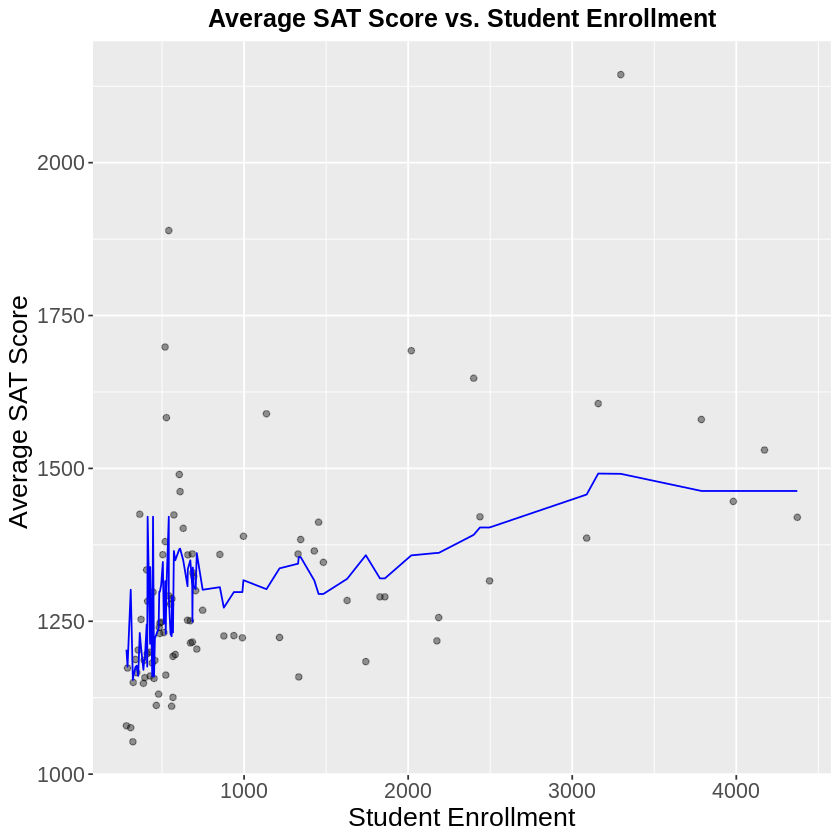

In [34]:
options(repr.plot.width = 7, repr.plot.height = 7)

sat_preds <- sat_fit %>%
                    predict(sat_training) %>%
                    bind_cols(sat_training)

sat_students_plot <- ggplot(sat_preds, aes(x = Student.Enrollment, y = total_score_avg)) + 
                geom_point(alpha = 0.4) +
                geom_line(data = sat_preds, aes(x = Student.Enrollment, y = .pred), color = 'blue') +
                ggtitle("Average SAT Score vs. Student Enrollment") +
                theme(plot.title = element_text(size = 18)) +
                theme(plot.title = element_text(face = "bold")) +
                theme(plot.title = element_text(hjust = 0.5)) +
                labs(x = "Student Enrollment", y = "Average SAT Score ") +
                theme(text = element_text(size = 16))

sat_students_plot

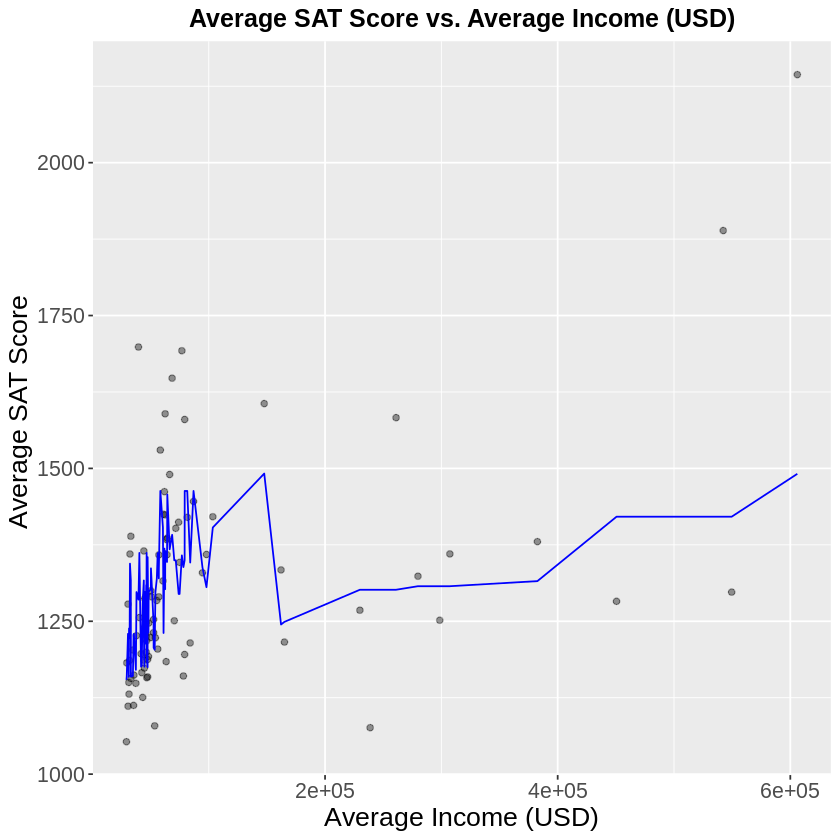

In [35]:
options(repr.plot.width = 7, repr.plot.height = 7)

sat_preds <- sat_fit %>%
                    predict(sat_training) %>%
                    bind_cols(sat_training)

sat_income_plot <- ggplot(sat_preds, aes(x = avg_income, y = total_score_avg)) + 
                geom_point(alpha = 0.4) +
                geom_line(data = sat_preds, aes(x = avg_income, y = .pred), color = 'blue') +
                ggtitle("Average SAT Score vs. Average Income (USD)") +
                theme(plot.title = element_text(size = 18)) +
                theme(plot.title = element_text(face = "bold")) +
                theme(plot.title = element_text(hjust = 0.5)) +
                labs(x = "Average Income (USD)", y = "Average SAT Score ") +
                theme(text = element_text(size = 16))

sat_income_plot

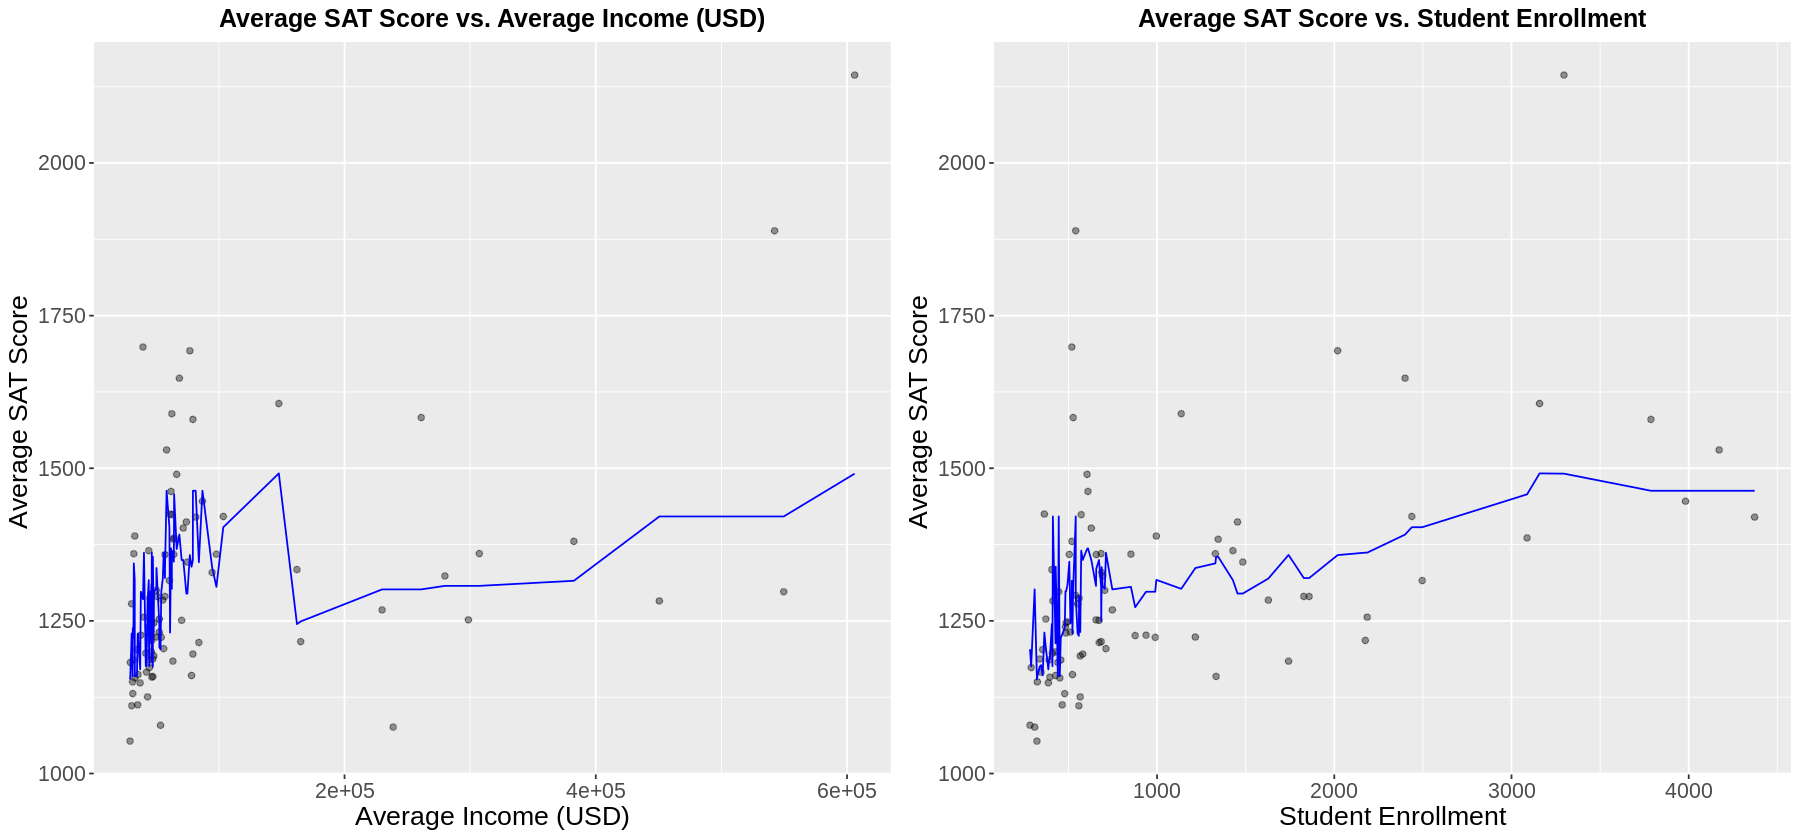

In [36]:
options(repr.plot.width = 15, repr.plot.height = 7)
plot_grid(sat_income_plot, sat_students_plot, ncol = 2)

### Discussion
 
We found that there is a correlation between SAT scores, and both family income and student population. Our model was able to predict student scores with an RMSE that averaged 100. While we did expect to find a correlation between these variables, the correlation we found was unexpected. We hypothesized that families with higher incomes will be able to not only send their kids to schools that provide higher levels of education, but will also have more preferable living situations, which in turn helps the students’ development. This hypothesis aligns with our results, and the studies of many other researchers. For example Mark Kantrowists states that “Students with family income of \\$100,000 or more are more than twice as likely as students with a family income under \\$50,000 to have combined SAT test scores of 1400 to 1600”. While income did have the correlation we expected, the student population was the complete opposite, with students attending more populated schools on average. We theorized that children attending less populated schools would have access to a more personalized learning experience, as well as more direct contact with their teachers. This is something that other studies have found, for example the Institute for Local self-reliance stated that “Hundreds of studies have found that students who attend small schools outperform those in large schools”. They also suggested this was because parents had the chance to be more involved in their children’s education. While we can’t be sure on why we found the complete opposite correlation, it could be due to the fact that in very densely populated urban environments, such as New York (where our data is from), less populated schools often tend to be in lower-income zones, and they’re low population not because they want to provide a better learning experience, but because of the low funding they receive.

Throughout our project we've also noticed some limitations. A factor that may have effected the results is a server limitation issue that was found. During our k-value computation, we found that there was a limitation issue while seeking for the best k-value. When we tried to compute with high k-values, such of those above 20, we ran out of memory and therefore it would display an error. Additionally, since the grading system has changed from the maximum score of 2400 to 1600, the model that we've created cannot be used for scores after March 2016.

The SAT (and ACT) test is often cited as making the American college admissions process more equitable, as people from all socioeconomic backgrounds will be sitting the same exam. However, like with all systems, it still is not perfect. Wealthier schools with higher faculty to student ratios, and are therefore able to provide better test prep services for their students. Given the nature of the SAT, it leads to questions of how socioeconomic factors can affect other factors of the college application: high school courses, GPA, extracurriculars, and essays. As American public schools are funded by property taxes, students from wealthier areas have access to better funded schools. These schools can use their extra funding to hire better teachers, build better classrooms, and offer more extracurricular activities and more diverse or advanced courses in their curriculum. All of which can affect a student’s college application.

In addition, wealth can also affect a student’s college prospects in ways not reflected in their application. As demonstrated by the college admissions scandal a few years ago, parents with resources are able to hire college consultants - often former admissions officers at highly selective schools - to help their kids craft the perfect college application. Therefore, some future questions this could lead to are: What is the correlation between the average income of a student's residential area, and the number of college acceptances it has? The number of acceptances to highly selective colleges?


### References

Gunasekara, H. (2021). Average Income per Zip Code USA 2018. Retrieved April 9, 2022 from https://www.kaggle.com/datasets/hamishgunasekara/average-income-per-zip-code-usa-2018.

ILSR. (n.d.). Small Schools vs. Big Schools. Retrieved April 9, 2022 from https://ilsr.org/rule/small-schools-vs-big-schools/#:~:text=One%20of%20the%20most%20effective,from%20grades%20to%20test%20scores.

Kantrowitz, M. (2021). Admissions Tests Discriminate Against College Admission of Minority and Low-Income Students at Selective Colleges. Retrieved April 9, 2022 from http://studentaidpolicy.com/sat-and-selectivity/.

NYC Open Data. (2017). Average SAT Scores for NYC Public Schools. Retrieved April 9, 2022 from https://www.kaggle.com/datasets/nycopendata/high-schools.
